In [1]:
from os import sys, path, getcwd
sys.path.append(path.dirname(getcwd()))

import numpy as np
import scipy.integrate as integrate
import scipy.stats as stats
import matplotlib.pyplot as plt
import ipywidgets as widgets
from particle_approximation import ParticleApproximation

In [2]:
plt.figure(figsize=(9,6))
plt.rc('font', size=15);

<Figure size 648x432 with 0 Axes>

# Bayesian Learning: The Pendulum Problem

In this notebook, we extend and reproduce the different experiments presented in our tutorial paper "A practical example for the non-linear Bayesian filtering of model parameters" [1].

The task is to estimate the gravitational acceleration of the Earth $g^\dagger \approx 9.808\ \text{m}\text{s}^{-2}$ from observations collected from a simple pendulum. We solve this inverse problem using the Bayesian approach and present its solution approximated by the Sequential Importance Sampling (SIS) and Sequential Monte Carlo (SMC) algorithms.

## 1. Modeling for the pendulum

To describe the dynamics of the pendulum, we used a simplified model described in §2.1 of the paper, given by the following initial value problem (IVP)

\begin{align*}
  \ddot{x}(\tau; g) &= -\frac{g}{\ell}\sin(x(\tau; g)),\\
  \dot{x}(0; g) &= v_0,\\
  x(0; g) &= x_0,
\end{align*}

where $x$ is the angle of pendulum, $g$ is the gravitational acceleration of the Earth, $l$ denotes the length of the string that connects the two ends of the pendulum (here $l = 7.4$), and $τ \in [0, \infty)$ denotes time.

Since the IVP describing the motion of the pendulum does not have an analytical solution, we use a numerical approximation instead. 

In [3]:
# We define for each value of g the correspounding right-hand side of the IVP.
def pendulum_rhs(x, t, g):
    d_x = x[1]
    d2_x = -g/7.4 * np.sin(x[0])
    return [d_x, d2_x]

# The pendulum is let go from a 5 degrees angle with no initial velocity.
x_0 = [5*np.pi/180, 0]

# We can then define a solution operator to compute the angle of the pendulum at given times.
def solve(g, times):
    sol = integrate.odeint(pendulum_rhs, x_0, times, args=(g,))
    return sol[:,0]

# Let's compare different trajetories of the pendulum for different values of g.
times = np.linspace(0, 20, 100)

def plot_solution(g):
    plt.xlabel("Time")
    plt.ylabel("Pendulum angle")
    plt.plot(times, solve(g, times), color="black")
    plt.show()
    
widgets.interact(plot_solution, g=(5,20,0.5));

interactive(children=(FloatSlider(value=12.0, description='g', max=20.0, min=5.0, step=0.5), Output()), _dom_c…

## 2. Pendulum filtering problem

We continue with the Bayesian formulation of the pendulum filtering problem. This consists of two parts:
1. define a prior distribution to encode existing knowledge about $g$,
2. model the measurements errors,
3. derive a sequence of likelihoods for the observed data.

### 2.1 Define a prior distribution
We follow the modelling choice presented in §3.2 of the paper and model the prior knowledge using a normal distribution of mean $10$ and variance $1$ truncated to the interval $[0, 20]$.

In [4]:
prior = stats.truncnorm(-10, 10, loc=10, scale=1) 

### 2.2 Model the measurements error
For the measurements errors, as presented in §3.2 of the paper, existing experiments [2] suggests that a typical visual reaction time for human is of $450\text{ms} \pm 100\text{ms}$. We encode this knowledge using a normal distribution of mean $0.45$ and standard deviation $0.1$. However, since the model considers the angle of the pendulum, we must translate this time error model to an angle error model. We do this by using a Monte Carlo estimate of the propagation of the time error through the solution of the IVP.

Estimate standard derivation of the angle error: 0.055875


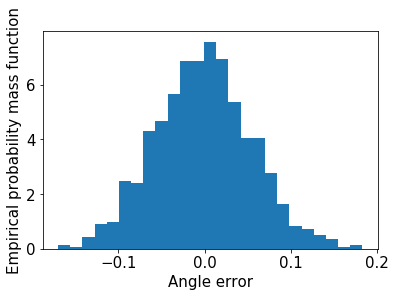

In [5]:
# We start computing a reference solution using the prior mean for exact time measurements.
ref_times = np.linspace(0, 30, 50)
ref_sol = solve(prior.mean(), ref_times)

# We then perturb the reference times and analyse the resulting error in the angles.
time_error_model = stats.norm(0.45, 0.1)

# The propagation of the error is estimate using a Monte Carlo estimate with 1000 samples.
angle_errors = np.zeros(1000)

for i in range(angle_errors.size):
    perturbed_times = np.sort(ref_times + time_error_model.rvs(ref_times.size))
    angle_errors[i] = (ref_sol - solve(prior.mean(), perturbed_times)).sum()
    
print("Estimate standard derivation of the angle error: %f" % angle_errors.std())
    
plt.xlabel("Angle error")
plt.ylabel("Empirical probability mass function")
plt.hist(angle_errors, bins=25, density=True);

The plot suggests that the angle error can be modelled using a normal distribution of mean $0$ and standard derivation $0.05$. Before moving on to the next section, we compare the simulated probability mass function of the angle error to the density of a $N(0, 0.05^2)$ distribution.

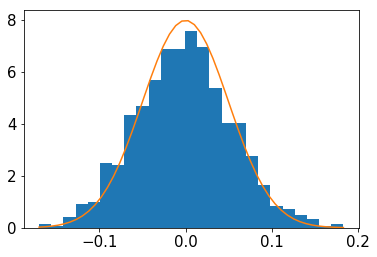

In [6]:
# First define the angle error model we have identified from the previous numerical experiment.
error_model = stats.norm(0,0.05)

# Then compare its density to the simulated probability mass function.
plt.hist(angle_errors, bins=25, density=True)

eval_mesh = np.linspace(np.min(angle_errors), np.max(angle_errors))
plt.plot(eval_mesh, error_model.pdf(eval_mesh));

### 2.3 Derive a sequence of likelihoods 

The last step of the Bayesian modelling of the filtering problem is to define a sequence of likelihood functions to sequentially incorporate the information of observations.

In [7]:
observations = np.array([1.51, 4.06, 7.06, 9.90, 12.66, 15.40, 15.58, 18.56, 21.38, 24.36])

# Add the initial time to the set of observation to solve the IVP at the proper times
evaluation_mesh = np.append(0, observations)

# For each time n, we define the correspounding joint log likelihood. We work with log likelihoods to
# avoid underflows in the calculations.
def loglikelihood(g, n):
    # At n=0, the only available information comes from the prior
    if n == 0:
        return prior.logpdf(g)
    return error_model.logpdf(solve(g, evaluation_mesh[:n+1])[1:]).sum()
    
# For convenience, we vectorize the loglikelihood to evaluate it on arrays.
vloglikelihood = np.vectorize(loglikelihood)

In [8]:
# We can then evaluate the sequence of posterior distributions
g_values = np.linspace(7.5, 12.5, 1000)
approx_densities = np.zeros((1000,observations.size+1))

for i in range(observations.size+1):
    approx_densities[:,i] = vloglikelihood(g_values,i)
    if i > 0:
        approx_densities[:,i] += vloglikelihood(g_values,0)
    
    approx_densities[:,i] = np.exp(approx_densities[:,i])
    approx_densities[:,i] /= approx_densities[:,i].sum()

# And visualize them.
colors = np.outer(0.75-0.75*(np.array(range(observations.size+1))/observations.size), np.ones(3))
def plot_densities(n):
    plt.xlabel("Gravitational acceleration")
    plt.ylabel("Probability density")
    plt.ylim(0,np.max(approx_densities)*1.1)
    for i in range(n+1):
        plt.plot(g_values, approx_densities[:,i], c=colors[i,:],label="t = %d"%i)
    plt.legend()
    plt.show()
    
widgets.interact(plot_densities, n=widgets.IntSlider(min=0,max=observations.size,step=1,value=0));

interactive(children=(IntSlider(value=0, description='n', max=10), Output()), _dom_classes=('widget-interact',…

## 3. Approximating the solution

We can now approximate the sequence of posteriors using the SMC and SIS algorithms as described in sections 4 and 5 of the paper. For now on, we only focus on the posterior distribution after observing all of the available data points.

For both of the methods, we approximate the posteriors using $2500$ particles and perform $5$ corrections of the positions using gaussian proposals.

In [9]:
def gaussian_proposal(x):
    return stats.norm(loc=x, scale=.25).rvs() 

We can then run the SIS estimation of the sequence of posteriors as described in §4.1.

In [10]:
# A SIS approximation is created using 2500 particles distributed according to the prior.
sis_approximation = ParticleApproximation(2500, prior)

# We also want to track the evolution of the Effectice Sample Size (ESS).
sis_ess_evolution = np.zeros(observations.size+1)
sis_ess_evolution[0] = 2500

# We then sequentially update the approximation to incorporate the new data.
for n in range(observations.size):
    importance_loglikelihood = lambda x: vloglikelihood(x, n)
    target_loglikelihood = lambda x: vloglikelihood(x, n+1)

    sis_approximation.reweight(importance_loglikelihood, target_loglikelihood)
    sis_ess_evolution[n+1] = sis_approximation.effective_sample_size() 

Approximated mean = 9.073609
Approximated variance = 0.103806


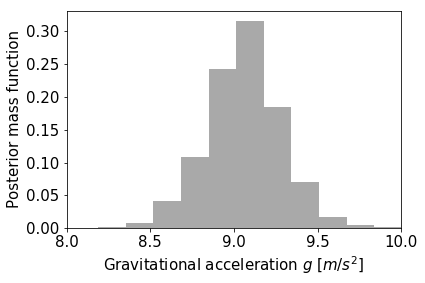

In [11]:
# Visualize the resulting approximation
plt.ylabel("Posterior mass function")
plt.xlabel("Gravitational acceleration $g$ [$m/s^2$]")
plt.xlim(8, 10)
sis_approximation.hist(bins=40, color="darkgrey")

# And evaluate moments of the posterior
print("Approximated mean = %f" % sis_approximation.integrate(lambda x: x))
print("Approximated variance = %f" % (sis_approximation.integrate(lambda x: x**2) - sis_approximation.integrate(lambda x: x)**2)) 

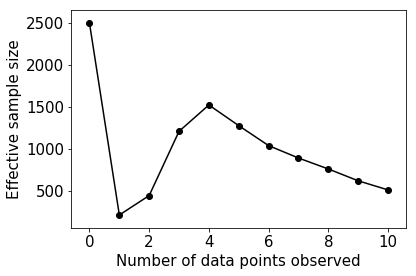

In [12]:
# However, the effective sample size is much lower than the actual number of particles. As explained in the paper
# this results in a poorer estimate for the same cost.
plt.xlabel("Number of data points observed")
plt.ylabel("Effective sample size")
plt.plot(sis_ess_evolution, color="black")
plt.scatter(range(observations.size+1),sis_ess_evolution, color="black"); 

To avoid particle degeneracy, we introduce a step of resampling as described in §4.2. This keeps the ESS above 75% of the target sample size and thus effectively use the (potentially) expensive evaluation of the likelihood.

In [13]:
# The SMC approximation is also created using 2500 particles distributed according to the prior.
smc_approximation = ParticleApproximation(2500, prior)

# We also want to track the evolution of the Effectice Sample Size (ESS).
smc_ess_evolution = np.zeros(observations.size+1)
smc_ess_evolution[0] = 2500

# We then sequentially update the approximation to incorporate the new data.
for n in range(observations.size):
    importance_loglikelihood = lambda x: vloglikelihood(x, n)
    target_loglikelihood = lambda x: vloglikelihood(x, n+1)

    _,ess = smc_approximation.smc_update(importance_loglikelihood, target_loglikelihood, gaussian_proposal, correction_steps=5, ess_ratio=1.3)
    smc_ess_evolution[n+1] = ess

Approximated mean = 9.124256
Approximated variance = 0.108597


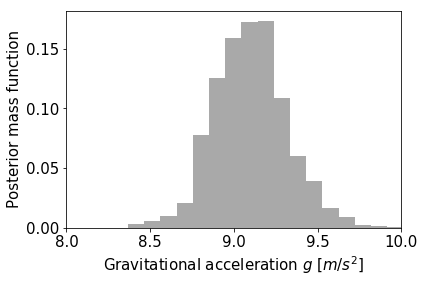

In [14]:
# Visualize the resulting approximation
plt.ylabel("Posterior mass function")
plt.xlabel("Gravitational acceleration $g$ [$m/s^2$]")
plt.xlim(8, 10)
smc_approximation.hist(bins=50, color="darkgrey")

# And evaluate moments of the posterior
print("Approximated mean = %f" % smc_approximation.integrate(lambda x: x))
print("Approximated variance = %f" % (smc_approximation.integrate(lambda x: x**2) - smc_approximation.integrate(lambda x: x)**2)) 

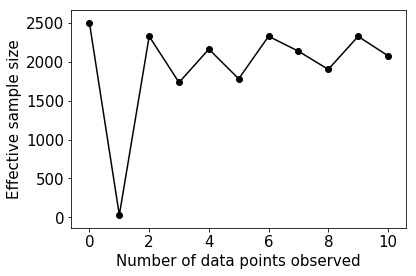

In [15]:
# This time, we see how the resampling allows to keep a high ESS and avoid particle degeneracy
plt.xlabel("Number of data points observed")
plt.ylabel("Effective sample size")
plt.plot(smc_ess_evolution, color="black")
plt.scatter(range(observations.size+1),smc_ess_evolution, color="black"); 

Knowing the real value of the parameter $g^\dagger$, we can evaluate the quality of the posterior by considering the cumulative distribution function of the relative error of the posterior. This is done in the following cell.

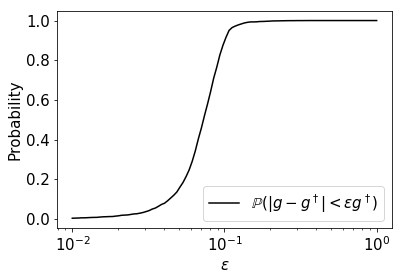

In [16]:
epsilons = np.logspace(-2,0,100)
probabilities = np.zeros_like(epsilons)
real_g = 9.808

for i in range(epsilons.size):
    # For each epsilon, estimate the probability of error by integrating the indicator function
    # of the corresponding event. 
    indicator_function = lambda g: 1 if (abs(g - real_g) <= epsilons[i] * real_g) else 0
    probabilities[i] = smc_approximation.integrate(indicator_function)

# And display it.
fig = plt.figure()
ax = plt.gca()

ax.set_xscale('log')
plt.xlabel("$\epsilon$")
plt.ylabel("Probability")
plt.plot(epsilons, probabilities, color="black", label="$\mathbb{P}(|g - g^\dagger| < \epsilon g^\dagger)$")
plt.legend();

A last informal assessement of the posterior distribution is to visually compare the forward propagated posterior to the set of observations. This is done by sampling values of $g$ from the posterior and solving the IVP for each of those values. The quality check can then be visually done by comparing the result to the measurements.

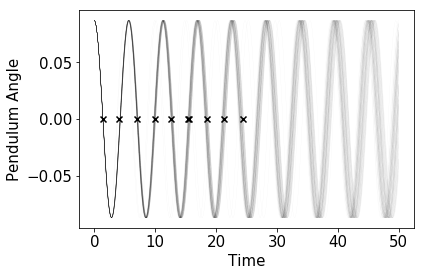

In [17]:
# Sample from the posterior 100 values of g.
sample_size = 100
posterior_sample = smc_approximation.sample(sample_size)
times = np.linspace(0, 50, 300)

# Then solve the IVP for each value of g and plot it
for i in range(sample_size):
    g = posterior_sample[i]
    plt.plot(times, solve(g, times), color="black", alpha=0.05, linewidth=0.2)

plt.scatter(observations, np.zeros_like(observations), color="black", marker="x")

plt.xlabel("Time")
plt.ylabel("Pendulum Angle");

### References 

[1] Bulté, M., Latz, J., Ullmann, E.: A practical example for the non-linear Bayesian filtering of model parameters, Submitted. (2018)

[2] Thorpe, S., Fize, D., Marlot, C.: Speed of processing in the human visual system. nature
381(6582), 520 (1996)